In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [13]:
base_dir = '/workspaces/waste-management/data'
train_dir = os.path.join(base_dir, '/workspaces/waste-management/data/train')
validation_dir = os.path.join(base_dir, '/workspaces/waste-management/data/validation')

# Directory with training organic pictures
train_organic_dir = os.path.join(train_dir, '/workspaces/waste-management/data/train/organic')

# Directory with training recyclable pictures
train_recycle_dir = os.path.join(train_dir, '/workspaces/waste-management/data/train/recyclable')

# Directory with validation organic pictures
validation_organic_dir = os.path.join(validation_dir, '/workspaces/waste-management/data/validation/organic')

# Directory with validation recyclable pictures
validation_recycle_dir = os.path.join(validation_dir, '/workspaces/waste-management/data/validation/recyclable')

print('total training organic images:', len(os.listdir(train_organic_dir)))
print('total training recycyle images:', len(os.listdir(train_recycle_dir)))
print('total validation organic images:', len(os.listdir(validation_organic_dir)))
print('total validation recycyle images:', len(os.listdir(validation_recycle_dir)))

total training organic images: 9999
total training recycyle images: 9999
total validation organic images: 1112
total validation recycyle images: 1112


(183, 275, 3)
(183, 275, 3)
(231, 219, 3)
(197, 255, 3)
(160, 314, 3)


(150, 300, 3)
(187, 269, 3)
(168, 300, 3)


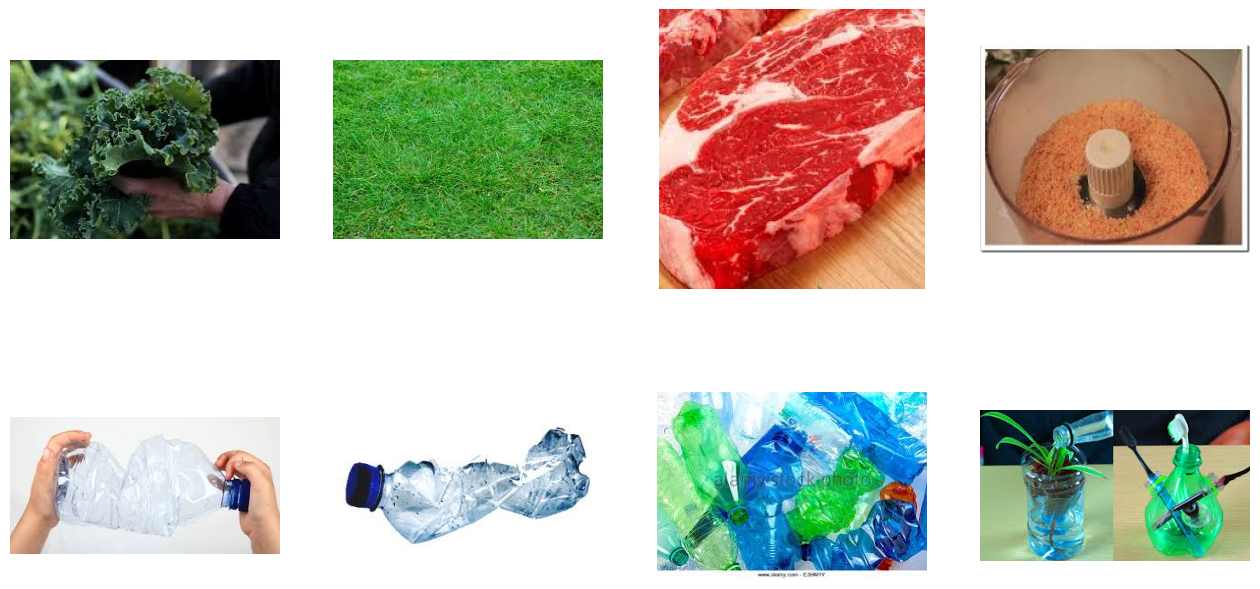

In [14]:
train_organic_fnames = os.listdir(train_organic_dir)
train_recycle_fnames = os.listdir(train_recycle_dir)
train_recycle_fnames.sort()

%matplotlib inline

# Parameters for our graph; we'll output images in a 2x4 configuration
nrows = 2
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 2x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows *4)

pic_index += 4
next_organic_pix = [os.path.join(train_organic_dir, fname) 
                for fname in train_organic_fnames[pic_index-4:pic_index]]
next_recycle_pix = [os.path.join(train_recycle_dir, fname) 
                for fname in train_recycle_fnames[pic_index-4:pic_index]]

for i, img_path in enumerate(next_organic_pix + next_recycle_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)
  print(img.shape)

plt.show()

In [15]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

2024-02-25 11:44:35.679696: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-25 11:44:35.723156: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 11:44:35.723202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 11:44:35.724456: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-25 11:44:35.731965: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-25 11:44:35.732911: I tensorflow/core/platform/cpu_feature_guard.cc:1

2024-02-25 11:44:36.940074: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,               # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        shuffle=True,
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        shuffle=True,
        class_mode='binary')

Found 19998 images belonging to 2 classes.
Found 2224 images belonging to 2 classes.


In [17]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

history = model.fit(
      train_generator,
      epochs=8,
      validation_data=validation_generator,
      verbose=2,
      shuffle=True)

Epoch 1/8
625/625 - 136s - loss: 0.4756 - acc: 0.7895 - val_loss: 0.3636 - val_acc: 0.8539 - 136s/epoch - 217ms/step
Epoch 2/8
625/625 - 132s - loss: 0.3880 - acc: 0.8368 - val_loss: 0.3381 - val_acc: 0.8534 - 132s/epoch - 212ms/step
Epoch 3/8
625/625 - 133s - loss: 0.3603 - acc: 0.8516 - val_loss: 0.2577 - val_acc: 0.8925 - 133s/epoch - 213ms/step
Epoch 4/8
625/625 - 133s - loss: 0.3303 - acc: 0.8654 - val_loss: 0.2622 - val_acc: 0.8966 - 133s/epoch - 212ms/step
Epoch 5/8
625/625 - 134s - loss: 0.3063 - acc: 0.8777 - val_loss: 0.3214 - val_acc: 0.8723 - 134s/epoch - 214ms/step
Epoch 6/8
625/625 - 142s - loss: 0.2693 - acc: 0.8929 - val_loss: 0.3161 - val_acc: 0.8781 - 142s/epoch - 228ms/step
Epoch 7/8
625/625 - 134s - loss: 0.2332 - acc: 0.9092 - val_loss: 0.2700 - val_acc: 0.9024 - 134s/epoch - 215ms/step
Epoch 8/8
625/625 - 133s - loss: 0.1904 - acc: 0.9290 - val_loss: 0.3707 - val_acc: 0.8867 - 133s/epoch - 213ms/step


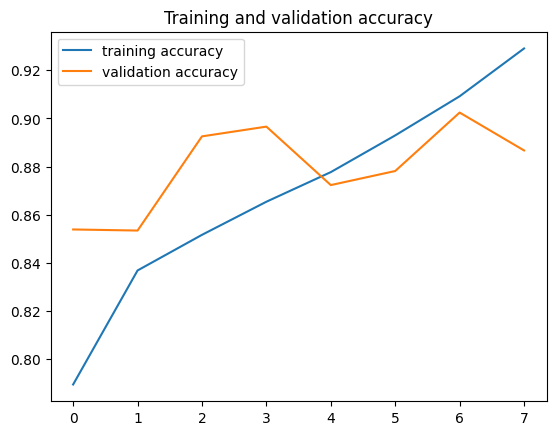

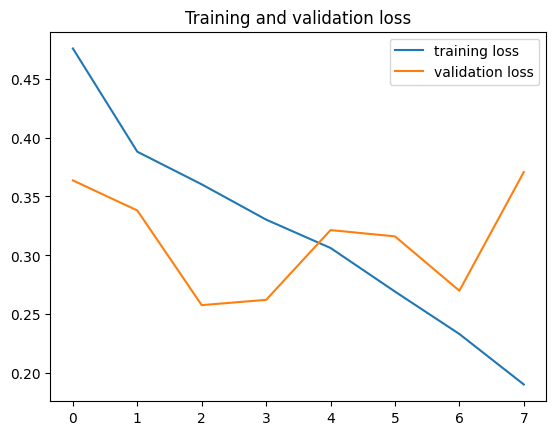

In [19]:
#@title Graphing accuracy and loss
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('Training and validation loss')
plt.legend()

In [20]:
# loading in the Inception v3 model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import SGD

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)


for layer in pre_trained_model.layers:
  layer.trainable = False


last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

--2024-02-25 12:05:33--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.70.91, 142.250.70.123, 142.251.42.123, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.70.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  16.2MB/s    in 6.8s    

2024-02-25 12:05:40 (12.3 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape: (None, 7, 7, 768)


In [21]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# Configure the model
model = Model(pre_trained_model.input, x)

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

2024-02-25 12:05:58.578083: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154140672 exceeds 10% of free system memory.
2024-02-25 12:05:58.689463: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154140672 exceeds 10% of free system memory.
2024-02-25 12:05:58.709527: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154140672 exceeds 10% of free system memory.


In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d_3[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0]

In [23]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=60,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/60


/tmp/ipykernel_7102/3787879127.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2024-02-25 12:07:27.832828: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154140672 exceeds 10% of free system memory.
2024-02-25 12:07:29.487771: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154140672 exceeds 10% of free system memory.


100/100 - 86s - loss: 0.3591 - acc: 0.8416 - val_loss: 0.3619 - val_acc: 0.8844 - 86s/epoch - 865ms/step
Epoch 2/60
100/100 - 83s - loss: 0.2460 - acc: 0.8997 - val_loss: 0.2295 - val_acc: 0.9119 - 83s/epoch - 826ms/step
Epoch 3/60
100/100 - 82s - loss: 0.2064 - acc: 0.9184 - val_loss: 0.2253 - val_acc: 0.9106 - 82s/epoch - 825ms/step
Epoch 4/60
100/100 - 82s - loss: 0.1854 - acc: 0.9312 - val_loss: 0.2485 - val_acc: 0.9187 - 82s/epoch - 819ms/step
Epoch 5/60
100/100 - 83s - loss: 0.1618 - acc: 0.9388 - val_loss: 0.4768 - val_acc: 0.8700 - 83s/epoch - 826ms/step
Epoch 6/60
100/100 - 82s - loss: 0.1495 - acc: 0.9418 - val_loss: 0.4796 - val_acc: 0.8750 - 82s/epoch - 821ms/step
Epoch 7/60
100/100 - 84s - loss: 0.1325 - acc: 0.9516 - val_loss: 0.2680 - val_acc: 0.9125 - 84s/epoch - 842ms/step
Epoch 8/60
100/100 - 83s - loss: 0.1322 - acc: 0.9494 - val_loss: 0.2136 - val_acc: 0.9319 - 83s/epoch - 827ms/step
Epoch 9/60
100/100 - 83s - loss: 0.1039 - acc: 0.9619 - val_loss: 0.3402 - val_acc:

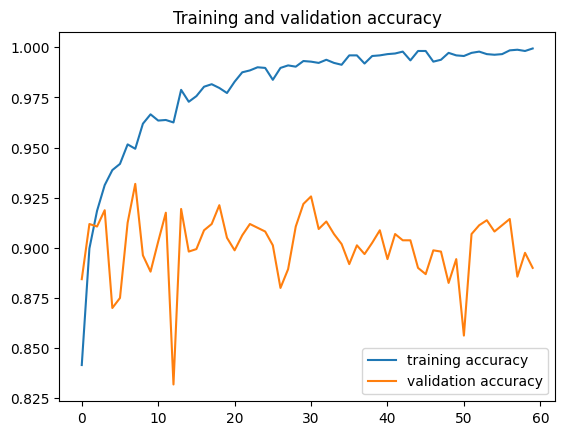

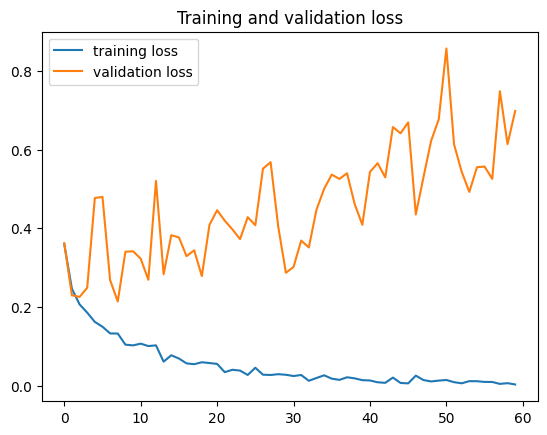

In [24]:
#@title Graphing accuracy and loss
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('Training and validation loss')
plt.legend()

In [25]:
# Flow validation images using val_datagen generator
val_visual = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        class_mode='binary',
        shuffle=True)

print(val_visual.class_indices)

Found 2224 images belonging to 2 classes.
{'organic': 0, 'recyclable': 1}


In [26]:
val_pred_prob = model.predict(val_visual)

70/70 [==============================] - 27s 381ms/step


In [27]:
# must get index array before getting predictions!
val_dir_indices = val_visual.index_array
val_true_labels = [0 if n < 1112 else 1 for n in val_dir_indices] # directory is sorted alphanumerically; 1st 1112: 'O', 2nd 1112: 'R'

# getting predictions in the form of probablities 
val_pred_prob = model.predict(val_visual)

# converting the probablities into binary values 
val_pred_labels = [1 if n >= 0.5 else 0 for n in val_pred_prob]

print("Model predictions: "+str(val_pred_labels))
print("Actual labels:     "+str(val_true_labels))

# determining the filepaths of misclassified waste
num_misclasssified = 0
misclassified_filepaths = []
correctness = []
for pred_label, true_label, dir_index in zip(val_pred_labels, val_true_labels, val_visual.index_array):
  misclassified_filepaths.append(val_visual.filepaths[dir_index])
  if pred_label != true_label:
    correctness.append('incorrect')
    num_misclasssified += 1
  else:
    correctness.append('correct')

print("# of total images: "+str(len(correctness)))
print("# of misclassified images: "+str(num_misclasssified))

70/70 [==============================] - 26s 377ms/step
Model predictions: [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 

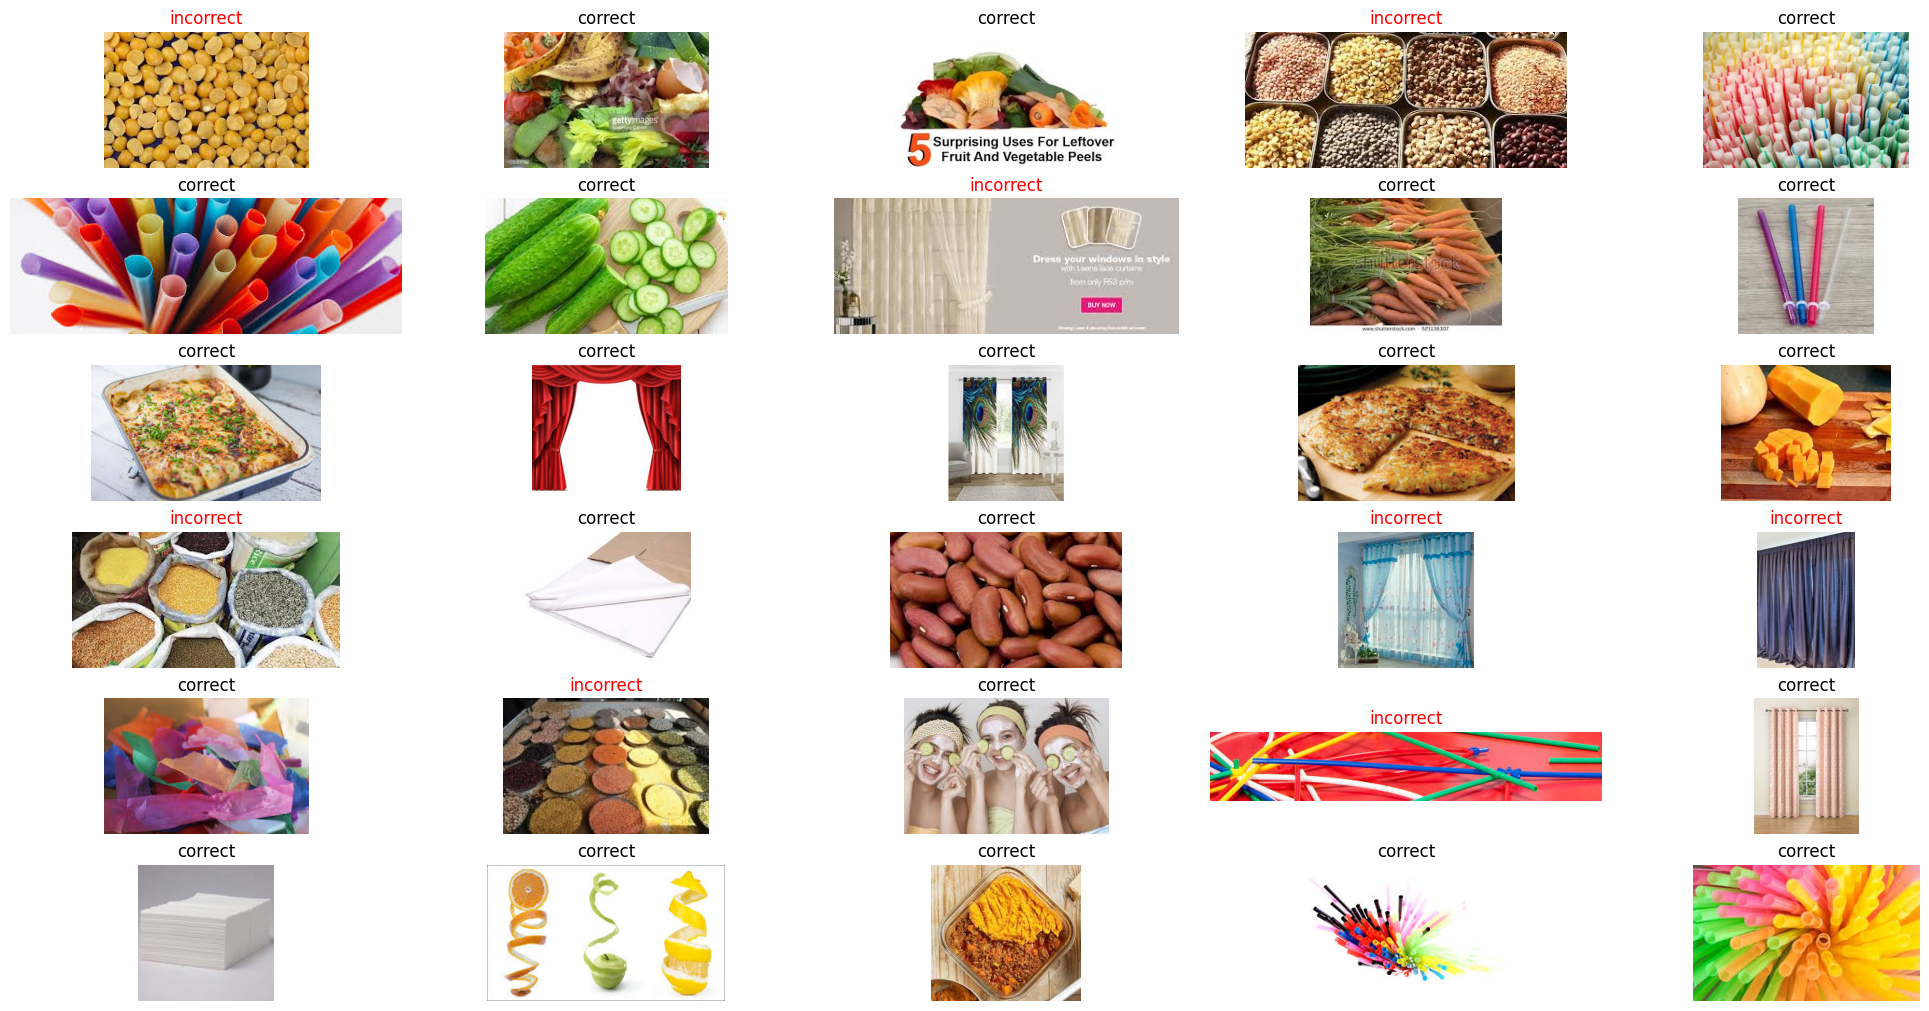

In [28]:
# obtain images from the filepath at the determined indices
misclassified_imgs = []
for filepath in misclassified_filepaths:
  misclassified_imgs.append(mpimg.imread(filepath))

# plot first 30 images
f, axarr = plt.subplots(6,5, figsize=(20,10), constrained_layout=True)  # plt.subplots(row,cols)
count = 0
for r in range(6):
  for c in range(5):
    axarr[r,c].imshow(misclassified_imgs[count])
    if correctness[count] == 'correct':
      axarr[r,c].set_title(correctness[count])
    else:
      axarr[r,c].set_title(correctness[count], color='red')
    axarr[r,c].set_axis_off()
    count += 1 
plt.show()

In [29]:

loss, acc = model.evaluate(validation_generator, verbose=1)
print("Accuracy using evaluate: "+str(acc))
print("Loss using evaluate: "+str(loss))

70/70 [==============================] - 27s 390ms/step - loss: 0.6933 - acc: 0.8930
Accuracy using evaluate: 0.8929855823516846
Loss using evaluate: 0.6933193206787109


In [30]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# confusion matrix
matrix = confusion_matrix(val_true_labels, val_pred_labels, labels=[0, 1])
print('Confusion matrix : \n',matrix, '\n')

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(val_true_labels, val_pred_labels, labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn, '\n')

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(val_true_labels, val_pred_labels, labels=[1,0])
print('Classification report : \n',matrix)
     

Confusion matrix : 
 [[1091   21]
 [ 217  895]] 

Outcome values : 
 895 217 21 1091 

Classification report : 
               precision    recall  f1-score   support

           1       0.98      0.80      0.88      1112
           0       0.83      0.98      0.90      1112

    accuracy                           0.89      2224
   macro avg       0.91      0.89      0.89      2224
weighted avg       0.91      0.89      0.89      2224

